# Basic Object Detector Demo

The following is a simple proof-of-concept demo showing how one can train a basic object detector. We use a sliding window to propose bounding boxes, and finetuned object classification network as the proposal acceptor. Note that this demo is solely built to give an idea about the parts that we need in an object detector.



- **Dataset:** [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/)

## Setup

### Download the Dataset and Set up the Environment

In [ ]:
%%shell
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

--2023-01-24 15:18:22--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  29.2MB/s    in 1.8s    

2023-01-24 15:18:24 (29.2 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-01-24 15:18:24--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-01-24 15:18:24--
Total wall clock time: 2.2s
Downloaded: 1 files, 51M in 1.8s (29.2 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
from torchvision import models, transforms
from torchvision.ops import generalized_box_iou
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches

## Dataset Loader

Below is a loader for the Penn-Fudan Database for Pedestrian Detection and Segmentation.

**Reference:** [Torchvision Object Detection Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

### Image Transforms and Training/Testing Set Setup

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.ConvertImageDtype(torch.float)
])

dataset = PennFudanDataset('PennFudanPed', transform)
# Split the dataset to train and test sets
indices = torch.randperm(len(dataset)).tolist()
train_set = torch.utils.data.Subset(dataset, indices[:-50])
test_set = torch.utils.data.Subset(dataset, indices[-50:])

### Check Data Points

In [ ]:
X, y = next(iter(dataset))
X.shape, y

(torch.Size([3, 536, 559]), {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [ ]:
def draw_boxes(image, bbs):
    # show
    img = transforms.ToPILImage()(image)
    height, width = img.size[0], img.size[1]
    fig, ax = plt.subplots(figsize=(15, 20))
    fig.set_facecolor('k')
    ax.imshow(img)
    ax.axis('off')

    # draw boxes
    for l in bbs:
        x, y, h, w = l[0], l[1], l[2] - l[0], l[3] - l[1]
        rect = patches.Rectangle((x, y), h, w, linewidth=2, edgecolor='w', facecolor='none')
        ax.add_patch(rect)
        ax.text(x+1, y - 5+1, 'person', color='k', fontsize=15)
        ax.text(x, y - 5, 'person', color='w', fontsize=15)

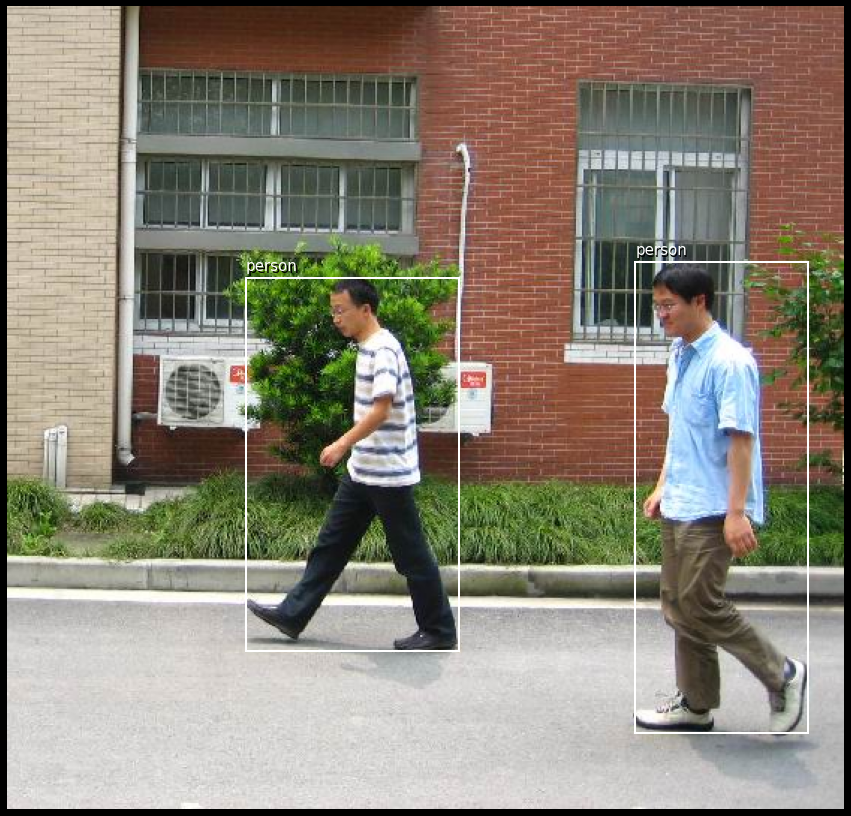

In [ ]:
draw_boxes(X, y['boxes'])

## Detection Model

Here, we introduce a basic object detector model to be trained and evaluated.

In [ ]:
import torch

from torchvision.utils import _log_api_usage_once
from torchvision.ops._utils import _upcast_non_float
from torchvision.ops.boxes import _box_inter_union

def intersection_calc(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    reduction: str = "none",
    eps: float = 1e-7,
) -> torch.Tensor:
    boxes1 = _upcast_non_float(boxes1)
    boxes2 = _upcast_non_float(boxes2)
    intsctk, unionk = _box_inter_union(boxes1, boxes2)
    return intsctk

In [ ]:
class BasicDetector(nn.Module):
    def __init__(self, input_size=224, roi_size=0.5, roi_step=0.1, ratio=0.3, thresh=0.5):
        super().__init__()
        self.classifier = models.resnet18(pretrained=True) # We use a resnet18 classifier for the model.
        self.classifier.fc = nn.Linear(512, 1)
        self.softmax = nn.Softmax(1)
        self.roi_size = roi_size
        self.roi_step = roi_step
        self.ratio = ratio
        self.thresh = thresh

    def propose(self, image, label):
        width, height = image.shape[1], image.shape[2]
        hsize = np.floor(self.roi_size * height).astype(int)
        hlim = height - hsize
        hstep = np.floor(self.roi_step * height).astype(int)
        wsize = np.floor(self.roi_size * width * self.ratio).astype(int)
        wlim = width - wsize
        wstep = np.floor(self.roi_step * width * self.ratio).astype(int)
        xs, bbs = [], []
        for top in range(0, hlim, hstep):
            for left in range(0, wlim, wstep):
                xs.append(image[:, left:left+wsize, top:top+hsize])
                bbs.append([top, left, top+hsize, left+wsize])
        self.boxes = torch.tensor(bbs)
        intersection_values = intersection_calc(label, self.boxes)
        aa = torch.max(intersection_values, dim=0).values
        return torch.stack(xs), torch.reshape(aa,(-1,1))

    def forward(self, x):
        return self.classifier(x)

    def getboxes(self, y):
        # 0 for person, 1 for background
        idx = torch.where(y[:, 0] > self.thresh)[0]
        print(idx)
        return y[idx, 0].detach(), self.boxes[idx, :]

In [ ]:
detector = BasicDetector(96, 0.4, 0.1, 1., 0.5)
Xs, ys = detector.propose(X, y['boxes'])
preds = detector(Xs)
conf, box = detector.getboxes(preds)
conf

tensor([ 0,  1,  2,  3,  4,  7,  8,  9, 10, 11, 14, 15, 17, 19, 24, 28, 35, 36,
        37, 38, 42, 43, 44, 45])


tensor([0.9176, 0.7309, 1.0178, 0.8155, 0.6570, 0.6356, 0.7499, 1.0002, 0.8987,
        0.6840, 1.1080, 0.8278, 0.6727, 0.5364, 0.5796, 0.6711, 0.6524, 0.6017,
        0.9228, 0.9342, 1.0271, 1.1359, 1.0385, 1.3997])

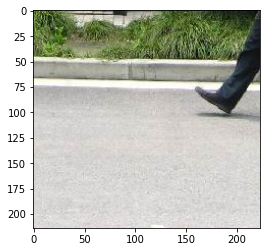

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.imshow(Xs[3,:,:,:].numpy().transpose((1,2,0)))

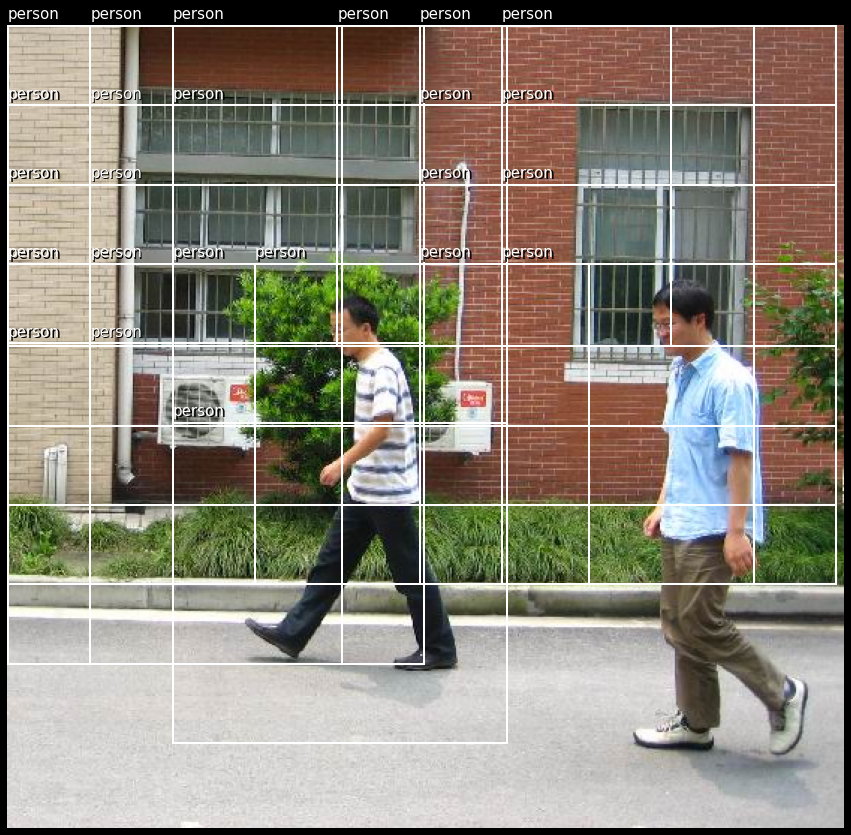

In [ ]:
draw_boxes(X, box)

## Train

Note that we use a rather basic training approach here.

In [ ]:
device = torch.device('cuda:0')

In [ ]:
model = detector = BasicDetector(64, 0.4, 0.2, 1., 0.25).to(device)
loss = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

for e in range(epochs):
    print('Epoch {}/{}:'.format(e + 1, epochs), end=' ')
    model.train()
    train = iter(train_set)
    train_loss = 0
    for i, (X, y) in enumerate(train):
        y = y['boxes']
        Xs, ys = model.propose(X, y)
        preds = model(Xs.to(device))
        l = loss(preds, ys.to(device))
        optim.zero_grad()
        l.backward()
        optim.step()
        train_loss += l

    with torch.no_grad():
        model.eval()
        test = iter(test_set)
        test_loss = 0
        for i, (X, y) in enumerate(test):
            y = y['boxes']
            Xs, ys = model.propose(X, y)
            preds = model(Xs.to(device))
            l = loss(preds, ys.to(device))
            test_loss += l

    print('train loss {:.4f}, test loss {:.4f}'.format(train_loss, test_loss))

Epoch 1/50: train loss 17524809728.0000, test loss 7274797056.0000
Epoch 2/50: train loss 17121288192.0000, test loss 7248965120.0000
Epoch 3/50: train loss 16392918016.0000, test loss 6805095424.0000
Epoch 4/50: train loss 15344924672.0000, test loss 6855665152.0000
Epoch 5/50: train loss 14033970176.0000, test loss 6322496512.0000
Epoch 6/50: train loss 12590402560.0000, test loss 6411812352.0000
Epoch 7/50: train loss 11139865600.0000, test loss 4626332160.0000
Epoch 8/50: train loss 9570196480.0000, test loss 4792160256.0000
Epoch 9/50: train loss 8107758080.0000, test loss 3654043392.0000
Epoch 10/50: train loss 6795965952.0000, test loss 3313607424.0000
Epoch 11/50: train loss 5641590272.0000, test loss 3394703872.0000
Epoch 12/50: train loss 4631211008.0000, test loss 2035653504.0000
Epoch 13/50: train loss 3839766784.0000, test loss 2236788224.0000
Epoch 14/50: train loss 3275317760.0000, test loss 2413513984.0000
Epoch 15/50: train loss 2847710976.0000, test loss 2234394880.00

## Test

In [ ]:
dset_n = 16
for i in enumerate(iter(train_set)):
  if i[0] == dset_n:
    X, y = i[1]

Xs, ys = detector.propose(X, y['boxes'])
preds = model(Xs.to(device))
idx = torch.where(preds[:,0] > 10000.)[0]
box = model.boxes[idx.cpu().numpy(),:]

tensor([[ 1516.2385],
        [ 1498.3521],
        [ 1606.9351],
        [ 2219.8286],
        [ 1331.2838],
        [ 1195.0248],
        [ 1769.7539],
        [ 2569.3994],
        [ 6618.2056],
        [13234.5498],
        [13252.2158],
        [ 9189.4990]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([ 9, 10], device='cuda:0')


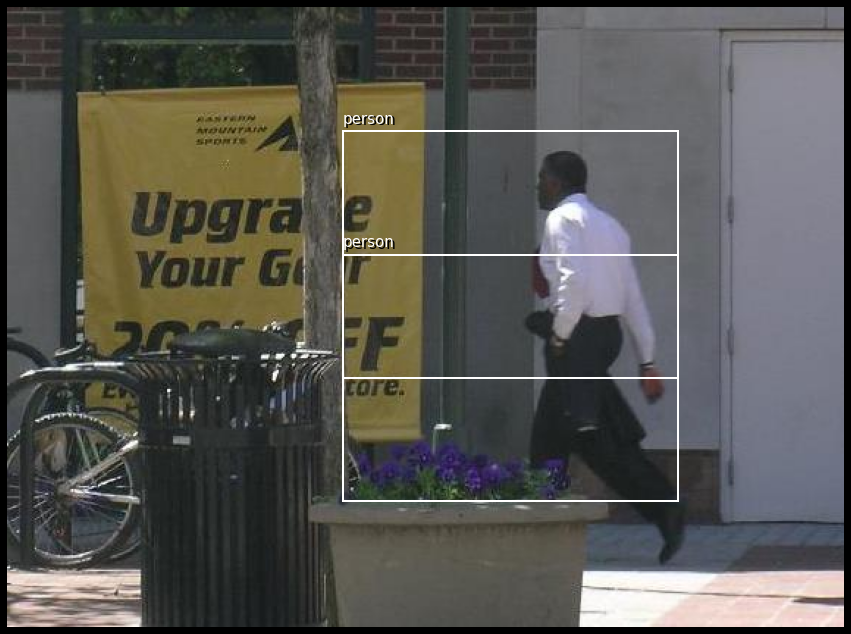

In [ ]:
draw_boxes(X, box)